<a href="https://colab.research.google.com/github/mamekin05108/signatecup2024summer/blob/main/CatBoost%2Bcali(LB0_8382866).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# warningsを非表示にする
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_train2.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_test2.csv")
ss = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/data/sample_submit.csv", header=None)

In [4]:
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,MonthlyIncome,ProdTaken,MaritalStatus,OwnCar,NumberOfChildren,Agebin,Incomebin,Occupation_Designation,FamilySize,TravelersRatio
0,0,50.0,Self Enquiry,2,15.0,Large Business,MALE,1.0,4.0,BASIC,...,253905.0,1.0,未婚,なし,0.0,41-50,<300000,Large Business_Executive,2.0,0.5
1,1,56.0,Company Invited,1,14.0,Salaried,MALE,1.0,4.0,STANDARD,...,404475.0,0.0,離婚,あり,0.0,51-65,<450000,Salaried_Senior Manager,1.0,1.0
2,2,NaN,Self Enquiry,1,10.0,Large Business,FEMALE,1.0,3.0,BASIC,...,278145.0,1.0,結婚,なし,0.0,NaN,<300000,Large Business_Executive,2.0,0.5
3,3,37.0,Self Enquiry,2,18.0,Small Business,FEMALE,1.0,3.0,STANDARD,...,326805.0,0.0,離婚,あり,0.0,31-40,<350000,Small Business_Senior Manager,1.0,1.0
4,4,48.0,Company Invited,3,17.0,Small Business,FEMALE,1.0,3.0,BASIC,...,258435.0,1.0,独身,あり,0.0,41-50,<300000,Small Business_Executive,1.0,1.0


In [5]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,100,45
2,TypeofContact,object,6,3
3,CityTier,int64,0,3
4,DurationOfPitch,float64,121,34
5,Occupation,object,0,3
6,Gender,object,0,2
7,NumberOfPersonVisiting,float64,0,4
8,NumberOfFollowups,float64,33,7
9,ProductPitched,object,0,5


In [6]:
# Config cell
target = "ProdTaken"
path_in_folder = "./"

cols_category = [
    "Gender",
    "ProductPitched",
    "Designation",
    "MaritalStatus",
    "OwnCar",
    "Occupation",
    "TypeofContact",
    "Agebin",
    "Incomebin",
    "Occupation_Designation"
]

In [7]:
def preprocess(df, replace_dict=None, ce_dict=None):
    # カテゴリカル変数の設定
    df[cols_category] = df[cols_category].fillna(-1)
    if replace_dict is None:
        # countencode, labelencode
        # ce_dict: 列名を入れるとそのカテゴリのデータがどのくらいあるかを返してくれます
        # replace_dict: 列名を入れるとlabelencodeのための数字を返してくれます
        ce_dict = {}
        replace_dict = {}
        for col in cols_category:
            replace_dict[col] = {}
            vc = df[col].value_counts()
            ce_dict[col] = vc
            replace_dict_in_dict = {}
            for i, k in enumerate(vc.keys()):
                replace_dict_in_dict[k] = i
            replace_dict[col] = replace_dict_in_dict
            df[f"{col}_CountEncode"] = df[col].replace(vc).astype(int)
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df, replace_dict, ce_dict

    # test
    else:
        for col in cols_category:
            # カウントエンコード
            test_vals_uniq = df[col].unique()
            ce_dict_in_dict = ce_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in ce_dict_in_dict.keys():
                    ce_dict_in_dict[test_val] = -1
            df[f"{col}_CountEncode"] = df[col].replace(ce_dict_in_dict).astype(int)

            # LabelEncode
            test_vals_uniq = df[col].unique()
            replace_dict_in_dict = replace_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in replace_dict_in_dict.keys():
                    replace_dict_in_dict[test_val] = -1
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df

In [8]:
df_train, replace_dict, ce_dict = preprocess(df_train)
df_test = preprocess(df_test, replace_dict=replace_dict, ce_dict=ce_dict)

In [9]:
df_train.head()


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,Gender_CountEncode,ProductPitched_CountEncode,Designation_CountEncode,MaritalStatus_CountEncode,OwnCar_CountEncode,Occupation_CountEncode,TypeofContact_CountEncode,Agebin_CountEncode,Incomebin_CountEncode,Occupation_Designation_CountEncode
0,0,50.0,0,2,15.0,2,0,1.0,4.0,0,...,2064,1157,1150,581,1785,361,2194,843,832,179
1,1,56.0,1,1,14.0,1,0,1.0,4.0,2,...,2064,841,854,878,1704,1401,1289,527,318,424
2,2,NaN,0,1,10.0,2,1,1.0,3.0,0,...,1425,1157,1150,1384,1785,361,2194,100,832,179
3,3,37.0,0,2,18.0,0,1,1.0,3.0,2,...,1425,841,854,878,1704,1727,2194,1126,1003,326
4,4,48.0,1,3,17.0,0,1,1.0,3.0,0,...,1425,1157,1150,646,1704,1727,1289,843,832,698


In [10]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,100,45
2,TypeofContact,int64,0,3
3,CityTier,int64,0,3
4,DurationOfPitch,float64,121,34
5,Occupation,int64,0,3
6,Gender,int64,0,2
7,NumberOfPersonVisiting,float64,0,4
8,NumberOfFollowups,float64,33,7
9,ProductPitched,int64,0,5


In [11]:
df_train.drop(["id"], axis=1, inplace=True)
df_test.drop(["id"], axis=1, inplace=True)

In [12]:
train_y = df_train[target]
train_x = df_train.drop(target, axis=1)

In [ ]:
#df_train.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_train.csv", index=False)
#df_test.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_test.csv", index=False)

In [13]:
params_lgb = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "colsample_bytree": 0.8,
    "subsample_freq": 1,
    "subsample": 0.8,
    "random_seed": 0,
}

In [14]:
params_cat = {
    "iterations": 3000,  # n_estimatorsに相当
    "learning_rate": 0.01,
    "colsample_bylevel": 0.8,  # colsample_bytreeに相当
    "random_seed": 0,
    "verbose": 100,  # 学習の進捗を100回毎に表示
    "use_best_model": True,  # 早期停止のための設定
}

In [15]:
# f1スコアが最も高くなる点を見つける
from sklearn import metrics
def decide_cutoff(val_y, preds_y_proba):
    mean_f1_list = []
    fpr, tpr, thresholds = metrics.roc_curve(val_y, preds_y_proba)
    for threshold in thresholds:
        preds_y = [1 if prob > threshold else 0 for prob in preds_y_proba]
        #preds_y=preds_y_proba
        mean_f1_list.append(f1_score(val_y, preds_y, average='macro'))
    return np.max(mean_f1_list), thresholds[np.argmax(mean_f1_list)]

In [16]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.4 MB/s eta 0:00:00


In [17]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.isotonic import IsotonicRegression

In [18]:
list_metrics_auc = []
list_metrics_f1 = []
list_cutoff = []
list_models = []
fraction_of_positives_list = []
mean_predicted_value_list = []

calibration_models = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (trn_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=1):
    trn_x = train_x.iloc[trn_idx, :]
    trn_y = train_y[trn_idx]
    val_x = train_x.iloc[val_idx, :]
    val_y = train_y[val_idx]
    train_pool = Pool(data=trn_x, label=trn_y, cat_features=cols_category)
    val_pool = Pool(data=val_x, label=val_y, cat_features=cols_category)

    model_cat = CatBoostClassifier(**params_cat, early_stopping_rounds=100)
    model_cat.fit(train_pool, eval_set=val_pool)

    list_models.append(model_cat)

    # Get the predicted probabilities on validation data
    val_pred_proba = model_cat.predict_proba(val_x)[:, 1]

    # Calibrate the probabilities manually using Isotonic Regression
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(val_pred_proba, val_y)
    calibrated_proba = iso_reg.transform(val_pred_proba)
    calibration_models.append(iso_reg)

    auc = roc_auc_score(val_y, calibrated_proba)
    f1, threshold = decide_cutoff(val_y, calibrated_proba)
    list_metrics_auc.append(auc)
    list_metrics_f1.append(f1)
    list_cutoff.append(threshold)
    print(f"Fold: {fold}, AUC: {auc}, f1 score: {f1} Threshold: {threshold}")

    # キャリブレーション曲線を計算
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, calibrated_proba, n_bins=10)
    fraction_of_positives_list.append(fraction_of_positives)
    mean_predicted_value_list.append(mean_predicted_value)

0:	learn: 0.6842099	test: 0.6844867	best: 0.6844867 (0)	total: 66.2ms	remaining: 3m 18s
100:	learn: 0.3519460	test: 0.3547620	best: 0.3547620 (100)	total: 1.74s	remaining: 50s
200:	learn: 0.3001610	test: 0.3093250	best: 0.3093250 (200)	total: 4.16s	remaining: 57.9s
300:	learn: 0.2783784	test: 0.2967110	best: 0.2967110 (300)	total: 7.31s	remaining: 1m 5s
400:	learn: 0.2665325	test: 0.2921241	best: 0.2921241 (400)	total: 11.2s	remaining: 1m 12s
500:	learn: 0.2563257	test: 0.2905576	best: 0.2905576 (500)	total: 15.6s	remaining: 1m 17s
600:	learn: 0.2478504	test: 0.2901194	best: 0.2899867 (565)	total: 18.4s	remaining: 1m 13s
700:	learn: 0.2401087	test: 0.2897602	best: 0.2896314 (631)	total: 20.8s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2896314348
bestIteration = 631

Shrink model to first 632 iterations.
Fold: 1, AUC: 0.8739046822742474, f1 score: 0.7624234172906739 Threshold: 0.15151515151515152
0:	learn: 0.6842863	test: 0.6844904	best: 0.6844

In [19]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.8509637638014643 0.7279815601366934 0.2608695652173913


0.838430501913626 0.7237247743604521 0.2595655837694162



In [ ]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.8527140753039351 0.7268991242790431 0.25


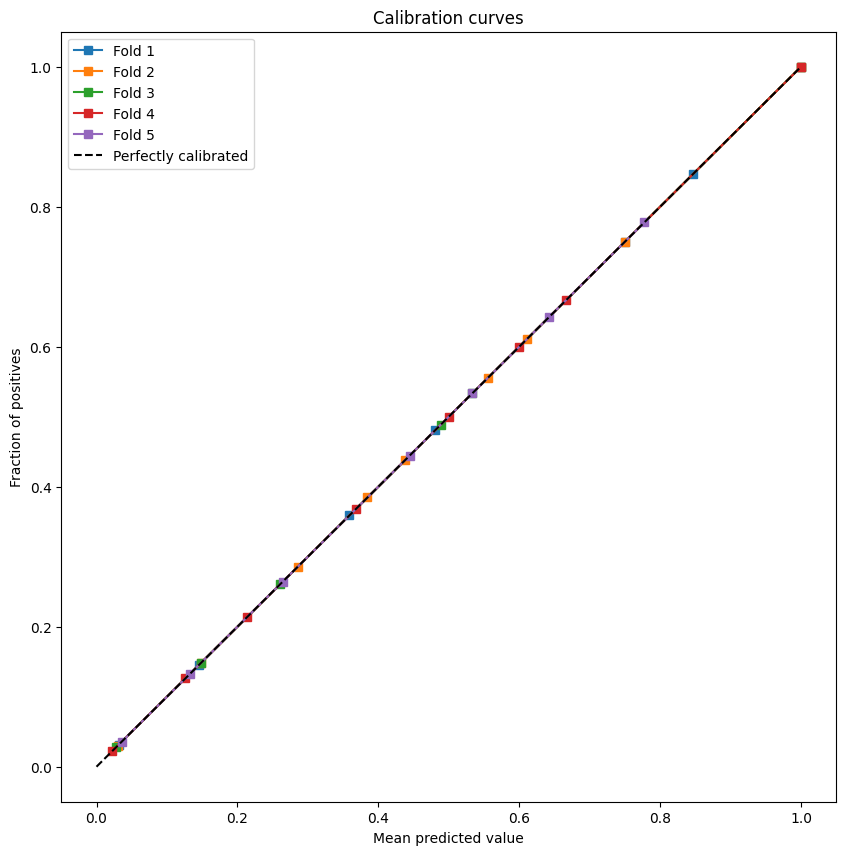

In [20]:
# キャリブレーション曲線の描画
plt.figure(figsize=(10, 10))
for i in range(cv.n_splits):
    plt.plot(mean_predicted_value_list[i], fraction_of_positives_list[i], "s-", label=f"Fold {i+1}")

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

In [21]:
threshold = np.median(list_cutoff)
preds_y_proba = np.zeros(len(df_test))
for model, calib_model in zip(list_models, calibration_models):
    # モデルに必要な特徴量を取得
    feature_names = model.feature_names_
    test_pred_proba = model.predict_proba(df_test[feature_names])[:, 1]
    calibrated_test_proba = calib_model.transform(test_pred_proba)
    preds_y_proba += calibrated_test_proba / len(list_models)
    print(f"Model: {model}, Proba: {preds_y_proba}")  # 予測確率を表示
preds_y = preds_y_proba

Model: <catboost.core.CatBoostClassifier object at 0x7c7f6eedd690>, Proba: [0.00869565 0.02857143 0.07179487 ... 0.17142857 0.07179487 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7c7f6eef92d0>, Proba: [0.0317045  0.06666667 0.15327635 ... 0.29365079 0.16703297 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7c7f6ed3f910>, Proba: [0.05948228 0.09571695 0.20545027 ... 0.49365079 0.21920688 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7c7f6ed3cb20>, Proba: [0.08045002 0.11676958 0.28045027 ... 0.62698413 0.29420688 0.        ]
Model: <catboost.core.CatBoostClassifier object at 0x7c7f6eeb37f0>, Proba: [0.09765432 0.15010291 0.33468755 ... 0.78253968 0.34844417 0.        ]


In [22]:
count = 0

In [23]:
from datetime import datetime
import pytz
# カウント変数をインクリメント
count += 1
# 日本時間を取得
japan_tz = pytz.timezone('Asia/Tokyo')
now = datetime.now(japan_tz)
timestamp = now.strftime("%Y%m%d_%H%M%S")

file_name = f"/content/drive/MyDrive/Signate/2024summer/catboost_cali_{timestamp}_{count:03d}.csv"
ss[1] = preds_y
ss.to_csv(file_name, header=False, index=False)